# Supervised Learning Algorithms for Football Outcome Prediction: An Empirical Analysis

In this Notebook, the preprocessed data will be used to predict the probability of a team winning, losing or drawing against any other opponent. The main objectives of this project is to survey the different types of supervised machine learning algorithms and identify the set of machine learning algorithms that are capable of predicting the outcome of a football match more accurately. Accordingly the following alogrithms will be evaluated.

        - Gaussian NB
        - Decision Tree
        - SVM
        - XGBoost, and
        - A simple custom Neural network architectue

### Importing Libraries

In [2]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

from joblib import dump, load

### Data preparation

In [2]:
matches_df = pd.read_csv('data_selected.csv')
y = matches_df.loc[:, 'label']
X = matches_df.drop('label', axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y.replace({-1:2,1:1,0:0},inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0, stratify=y)\

best_models={}

## Decision Tree

In [3]:

from sklearn.tree import DecisionTreeClassifier, plot_tree

model_dte = DecisionTreeClassifier(random_state=0)
param_dte ={ 'criterion' : ['gini', 'entropy'],
             'max_depth' : [2,4,6,8,10,12]
           }

model_grid_dte = GridSearchCV(model_dte,param_dte, n_jobs=-1)
model_grid_dte.fit(X_train, y_train)
model_grid_dte.best_score_

0.5022457318194344

In [4]:
best_models['Decision tree'] = model_grid_dte.best_estimator_
dump(model_grid_dte.best_estimator_, './models/decision_tree_best.joblib')
model_grid_dte.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)

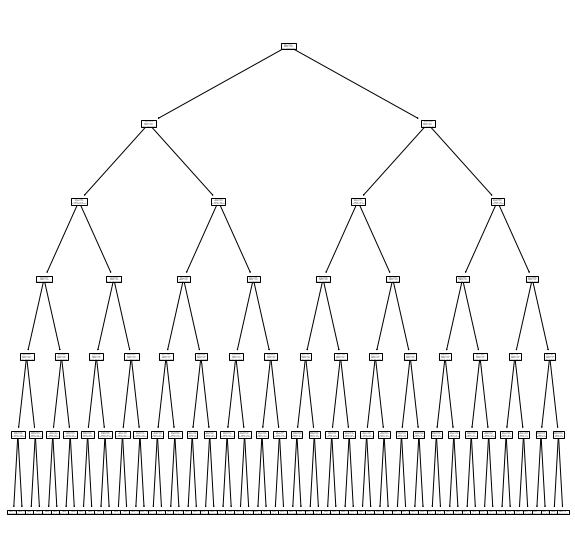

In [5]:
# visualize the tree
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plot_tree(model_grid_dte.best_estimator_)
plt.show()

In [6]:
# Visualize the tree
import numpy as np

n_nodes = model_grid_dte.best_estimator_.tree_.node_count
children_left = model_grid_dte.best_estimator_.tree_.children_left
children_right = model_grid_dte.best_estimator_.tree_.children_right
feature = model_grid_dte.best_estimator_.tree_.feature
threshold = model_grid_dte.best_estimator_.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] ,
                node=i,
                left=children_left[i],
                feature=list(matches_df.columns)[feature[i]],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 127 nodes and has the following tree structure:

0node=0 is a split node: go to node 1 if X[:, potential_home_6] <= 0.7024027705192566 else to node 64.
1node=1 is a split node: go to node 2 if X[:, overall_rating_away_2] <= 0.755084753036499 else to node 33.
2node=2 is a split node: go to node 3 if X[:, overall_rating_home_3] <= 0.5307328701019287 else to node 18.
3node=3 is a split node: go to node 4 if X[:, standing_tackle_away_4] <= 0.5965777635574341 else to node 11.
4node=4 is a split node: go to node 5 if X[:, overall_rating_home_8] <= 0.4979967921972275 else to node 8.
5node=5 is a split node: go to node 6 if X[:, marking_away_4] <= 0.6927711069583893 else to node 7.
						node=6 is a leaf node.
						node=7 is a leaf node.
5node=8 is a split node: go to node 9 if X[:, overall_rating_away_8] <= 0.399469330906868 else to node 10.
						node=9 is a leaf node.
						node=10 is a leaf node.
4node=11 is a split node: go to node 12 if X[:, overall_rating_

## Naive Bayes Classifier

In [7]:
from sklearn.naive_bayes import GaussianNB

model_gnb = GaussianNB()

param_gnb = {var_smoothing=np.logspace(0,-9, num=100)}


model_grid_gnb = GridSearchCV(model_gnb,param_gnb, n_jobs=-1)
print(f'The best Score: {model_grid_gnb.best_score_}')

              precision    recall  f1-score   support

           0       0.24      0.30      0.26       950
           1       0.63      0.61      0.62      2197
           2       0.53      0.47      0.50      1531

    accuracy                           0.50      4678
   macro avg       0.46      0.46      0.46      4678
weighted avg       0.52      0.50      0.51      4678



In [8]:
best_models['Gaussian Naive bayes'] = model_grid_gnb.best_estimator_
dump(model_grid_gnb.best_estimator_, './models/GaussianNB_best.joblib')

{'Decision tree': DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0),
 'Gaussian Naive bayes': GaussianNB()}

## Logestic regression

In [9]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(solver='liblinear', class_weight='balanced')

param_log={"C":np.logspace(-3,3,7), 
      "penalty":["l1","l2"]}

model_grid_log = GridSearchCV(model_log,param_log, n_jobs=-1)
model_grid_log.fit(X_train, y_train)
print(f'The best Score: {model_grid_log.best_score_}')

The best Score: 0.5269941142190394


In [10]:
dump(model_grid_log.best_estimator_, './models/logistic_regression_best.joblib')
best_models['Logestic Regression'] = model_grid_log.best_estimator_

In [11]:
best_models

{'Decision tree': DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0),
 'Gaussian Naive bayes': GaussianNB(),
 'Logestic Regression': LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')}

## SVM Classifier

In [12]:

model_svc = SVC()
param_svc = {'C': [0.1, 1, 10, 100, 1000], 
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf', 'polynomial'],
             'degree': [2, 3, 4]
             } 

model_grid_svm = GridSearchCV(model_svc,param_svc, n_jobs=-1)
model_grid_svm.fit(X_train, y_train)
print(f'The best Score: {model_grid_svm.best_score_}')

/home/rufael.marew/.conda/envs/ml701/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.53046835        nan 0.52934581        nan 0.45841352        nan
 0.45841352        nan 0.45841352        nan 0.53046835        nan
 0.52934581        nan 0.45841352        nan 0.45841352        nan
 0.45841352        nan 0.53046835        nan 0.52934581        nan
 0.45841352        nan 0.45841352        nan 0.45841352        nan
 0.53223203        nan 0.53169775        nan 0.53127023        nan
 0.45841352        nan 0.45841352        nan 0.53223203        nan
 0.53169775        nan 0.53127023        nan 0.45841352        nan
 0.45841352        nan 0.53223203        nan 0.53169775        nan
 0.53127023        nan 0.45841352        nan 0.45841352        nan
 0.52539039        nan 0.53062848        nan 0.53314093        nan
 0.53121677        nan 0.45841352        nan 0.52539039        nan
 0.53062848        nan 0.533140

The best Score: 0.533996189107912


In [13]:
dump(model_grid_svm.best_estimator_, './models/svm_best.joblib')
best_models['SVM'] = model_grid_svm.best_estimator_
model_grid_svm.best_estimator_

SVC(C=1000, degree=2, gamma=0.0001)

## XGBoost

In [14]:
from xgboost import XGBClassifier



model_xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=16, verbosity=1,random_state=0)

param_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.4,0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model_grid_xgb = GridSearchCV(model_xgb,param_xgb, n_jobs=-1)
model_grid_xgb.fit(X_train, y_train)
print(f'The best CV Score: {model_grid_xgb.best_score_}')

/home/rufael.marew/.conda/envs/ml701/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:41:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The best CV Score: 0.5316441769171719


In [15]:
# dump(model_grid_xgb.best_estimator_, './models/xgb_best.joblib')
model_grid_xgb.best_estimator_.save_model('xgb_best.json')
best_models['XGBoost']=model_grid_xgb.best_estimator_
model_grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, silent=True,
              subsample=0.6, tree_method='exact', validate_parameters=1, ...)

In [16]:
model_grid_xgb.best_score_

0.5316441769171719

### Neural Network

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Using device cuda


In [29]:
matches_df = pd.read_csv('./database/data_partially_preprocessed.csv')
y = matches_df.loc[:, 'label']
X = matches_df.drop('label', axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y.replace({-1:2,1:1,0:0},inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0, stratify=y)

In [50]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None, train=False):
        
#         self.data = pd.read_csv(data_dir)
        try:
            self.data = pd.read_csv(data_dir)
        except CParserError:
            print ("Something is wrong with the file")
            
        self.labels = self.data.loc[:, 'label']
        self.X = self.data.drop('label', axis=1)
        
        self.transform = transform
        self.transform.fit(self.X)
        temp_train, temp_test, y_train, y_test = train_test_split(self.X, self.labels, test_size=0.2,random_state=0, stratify=self.labels)
        if train:
            self.X = temp_train
            self.labels = y_train
        else:
            self.X = temp_test
            self.labels = y_test
            
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = self.X.iloc[idx, :].to_numpy().reshape(1, -1)
        label = self.labels.iloc[idx]
        if self.transform:
            features = self.transform.transform(features)
#         if self.target_transform:
#             label = nn.functional.one_hot(torch.tensor(label), num_classes=3)       
        features, label = torch.tensor(features.flatten()).float(), label
        
        return features, label

In [66]:

data_train = DataLoader(CustomDataset(data_dir='./database/data_partially_preprocessed.csv',transform=MinMaxScaler(),train=True,\
                                      target_transform=True),\
                                      batch_size=256, shuffle=True)

data_test = DataLoader(CustomDataset(data_dir='./database/data_partially_preprocessed.csv',transform=MinMaxScaler(),\
                                     target_transform=True)\
                                     , batch_size=256, shuffle=True)



In [67]:
x_data,y_data = next(iter(data_test))
print(f'Shape of one batch features: {x_data.shape}')
print(f'Shape of one batch label: {y_data.shape}')

Shape of one batch features: torch.Size([256, 979])
Shape of one batch label: torch.Size([256])


In [68]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden):
        super(Net, self).__init__()
        
        self.fcin = nn.Linear(input_dim, hidden[0])
        self.act1 = nn.ReLU()
        
        layer = [self.fcin, self.act1]
        for i in range(len(hidden)-1):
            self.fc = nn.Linear(hidden[i], hidden[i+1])
            self.act = nn.ReLU()
            layer.append(self.fc)
            layer.append(self.act)
       
        self.fcout = nn.Linear(hidden[-1],3)
        layer.append(self.fcout)
        self.soft = nn.Softmax(dim=1)
        layer.append(self.soft)
        
        self.model = nn.Sequential(*layer)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [69]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, epoch=1):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    precision, recall, f1 = 0,0,0
    
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            precision+= precision_score(pred.argmax(1).cpu(),y.cpu(), average='weighted')
            recall+= recall_score(pred.argmax(1).cpu(),y.cpu(),average='weighted',zero_division=0)
            f1+= f1_score(pred.argmax(1).cpu(),y.cpu(),average='weighted',zero_division=0)
            
    test_loss /= num_batches
    correct /= size
    precision/= num_batches
    recall/= num_batches
    f1/= num_batches
    
    print(f"Test result epoch {epoch}: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Precision: {(100*precision):>0.1f}%,")
    print(f"recall: {(100*recall):>0.1f}%, ")
    print(f"f1: {(100*f1):>0.1f}%, ")
    
    
#     if epoch%10==0 or epoch==1:
#         test_loss /= num_batches
#         correct /= size
#         print(f"Test result epoch {epoch}: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
model = Net(979, [64, 128, 4, 32, 32, 32, 8, 32, 128, 16, 64, 256, 4, 4, 64, 16]).to(device)

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 40
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_train, model, loss_fn, optimizer)
    
    if t%10==0:
        test_loop(data_test, model, loss_fn,epoch=t)

print('Final Result:\n')
test_loop(data_test, model, loss_fn,epoch=t)
print("Done!")

Test result epoch 0: 
 Accuracy: 45.8%, Avg loss: 1.094577 

Precision: 100.0%,
recall: 46.0%, 
f1: 63.0%, 
Test result epoch 10: 
 Accuracy: 45.8%, Avg loss: 1.066553 

Precision: 100.0%,
recall: 45.7%, 
f1: 62.7%, 
Test result epoch 20: 
 Accuracy: 45.8%, Avg loss: 1.062451 

Precision: 100.0%,
recall: 46.3%, 
f1: 63.2%, 
Test result epoch 30: 
 Accuracy: 45.8%, Avg loss: 1.066775 

Precision: 100.0%,
recall: 45.4%, 
f1: 62.3%, 
Final Result:

Test result epoch 39: 
 Accuracy: 45.8%, Avg loss: 1.063479 

Precision: 100.0%,
recall: 46.0%, 
f1: 63.0%, 
Done!


### Grid search for NN

In [27]:
from functools import partial
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [28]:
def load_data(data_dir="./database/data_selected.csv"):

    data_train = CustomDataset(data_dir=data_dir,transform=MinMaxScaler(),train=True,\
                                      target_transform=True)

    data_test = CustomDataset(data_dir=data_dir,transform=MinMaxScaler(),\
                                     target_transform=True)

    return data_train, data_test

In [29]:
def gen_net(size,seed=0):
    np.random.seed(seed)
    temp=[]
    for i in range(size):
        temp.append(2**np.random.randint(2, 9))
    return temp
gen_net(6)

[64, 128, 4, 32, 32, 32]

In [30]:
def grid_nn(config, checkpoint_dir=None, data_dir=None):
    
    net = Net(28, config["hidden"])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    print(f'\nworking on {device} device\n')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data()

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    print(len(trainloader))
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

#         with tune.checkpoint_dir(epoch) as checkpoint_dir:
#             path = os.path.join(checkpoint_dir, "checkpoint")
#             torch.save((net.state_dict(), optimizer.state_dict()), path)
        print("accuracy: {}".format(correct/total))
        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [31]:
def test_accuracy(net):
    trainset, testset = load_data()
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        
    net.to(device)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            features, labels = data
            features, labels = features.to(device), labels.to(device)
            outputs = net(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total)

### !!! The Below cell takes approximatelly 8hrs to complete

In [33]:
data_dir = os.path.abspath("./database")

num_samples=10
max_num_epochs=30
gpus_per_trial=1
net_size=64

net_arc = [gen_net(net_size,seed=i) for i in range(net_size)]

config = {
    "hidden": tune.choice(net_arc),            
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["hidden", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
    partial(grid_nn, data_dir=data_dir),
    resources_per_trial={"cpu": 32, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

2022-11-26 22:45:54,305	INFO worker.py:1528 -- Started a local Ray instance.
/home/rufael.marew/.conda/envs/ml701/lib/python3.6/site-packages/ray/tune/trainable/function_trainable.py:611: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,


== Status ==
Current time: 2022-11-26 22:45:56 (running for 00:00:00.24)
Memory usage on this node: 43.6/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |
|---------------------+----------+----------------------+----------------------+-------------+--------------|
| grid_nn_8fe16_00000 | RUNNING  | 10.127.30.24:2127182 | [64, 128, 4, 32_2b48 | 0.0237233   |           16 |
| grid_nn_8fe16_00001 | PENDING  |                      | [64, 128

(func pid=2127182) accuracy: 0.4561731694281133


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
grid_nn_8fe16_00000,0.456173,2022-11-26_22-48-07,True,,35a3e695b7cb4343a5c671193acf61c9,ws-l1-014,10,1.07019,10.127.30.24,2127182,125.741,12.3821,125.741,1669488487,0,,10,8fe16_00000,0.00541353
grid_nn_8fe16_00001,0.462854,2022-11-26_22-51-24,True,,1925aa9652e841bc85a474d26c826ab6,ws-l1-014,4,1.06633,10.127.30.24,2136293,191.508,47.4952,191.508,1669488684,0,,4,8fe16_00001,0.00471067
grid_nn_8fe16_00002,0.46713,2022-11-26_22-53-43,True,,366f3b3aae884459878502f6b2f29909,ws-l1-014,10,1.0597,10.127.30.24,2143537,132.688,13.1298,132.688,1669488823,0,,10,8fe16_00002,0.00680971
grid_nn_8fe16_00003,0.459647,2022-11-26_22-54-17,True,,0c3970c2e20a4e589bf3ecbc6164e849,ws-l1-014,1,1.06491,10.127.30.24,2152977,29.2542,29.2542,29.2542,1669488857,0,,1,8fe16_00003,0.00548387
grid_nn_8fe16_00004,0.445751,2022-11-26_22-54-39,True,,033021d6ddff489390a3a45ca9ac3959,ws-l1-014,1,1.0712,10.127.30.24,2154622,17.0023,17.0023,17.0023,1669488879,0,,1,8fe16_00004,0.00599122
grid_nn_8fe16_00005,0.450027,2022-11-26_22-55-35,True,,176b5c67094f4d79a400bd2d3a491eaa,ws-l1-014,1,1.07378,10.127.30.24,2155753,50.7832,50.7832,50.7832,1669488935,0,,1,8fe16_00005,0.00664186
grid_nn_8fe16_00006,0.455104,2022-11-26_22-57-17,True,,3ceb812e1f30473fac32ba369915cafb,ws-l1-014,1,1.06599,10.127.30.24,2157863,96.4115,96.4115,96.4115,1669489037,0,,1,8fe16_00006,0.00501943
grid_nn_8fe16_00007,0.459914,2022-11-26_22-57-53,True,,51573cf12ef849408c2e151dea1860ab,ws-l1-014,2,1.06355,10.127.30.24,2161579,30.1539,12.5517,30.1539,1669489073,0,,2,8fe16_00007,0.00583124
grid_nn_8fe16_00008,0.520844,2022-11-26_23-06-09,True,,8473470bc5ed4f4888d5bc5cab21f481,ws-l1-014,10,1.0028,10.127.30.24,2163572,491.18,49.2519,491.18,1669489569,0,,10,8fe16_00008,0.0081594
grid_nn_8fe16_00009,0.450561,2022-11-26_23-06-32,True,,fc0a52e17f1e45bead6948568baa0af7,ws-l1-014,1,1.06903,10.127.30.24,2183024,16.7725,16.7725,16.7725,1669489592,0,,1,8fe16_00009,0.00422168


== Status ==
Current time: 2022-11-26 22:46:23 (running for 00:00:26.86)
Memory usage on this node: 44.5/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------|
| grid_nn_8fe16_00000 | 

(func pid=2127182) accuracy: 0.4561731694281133
== Status ==
Current time: 2022-11-26 22:46:47 (running for 00:00:51.33)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+----------+----------------------+----------------------+-------------+--------------+--------

== Status ==
Current time: 2022-11-26 22:47:05 (running for 00:01:08.58)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+------------------

(func pid=2127182) accuracy: 0.4561731694281133
== Status ==
Current time: 2022-11-26 22:47:23 (running for 00:01:27.24)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+--------+------------+----------------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |   loss |   accuracy |   training_iteration |
|---------------------+----------+----------------------+----------------------+-------------+----------

== Status ==
Current time: 2022-11-26 22:47:40 (running for 00:01:44.40)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+------------------

(func pid=2127182) accuracy: 0.4561731694281133
== Status ==
Current time: 2022-11-26 22:48:00 (running for 00:02:04.01)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status   | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+----------+----------------------+----------------------+--------

(func pid=2136293) 
(func pid=2136293) working on cuda device
(func pid=2136293) 
(func pid=2136293) 3742
== Status ==
Current time: 2022-11-26 22:48:18 (running for 00:02:22.04)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|-----------

== Status ==
Current time: 2022-11-26 22:48:33 (running for 00:02:37.09)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+-------

== Status ==
Current time: 2022-11-26 22:48:48 (running for 00:02:52.14)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.066049483596769
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+-------

(func pid=2136293) accuracy: 0.46285408872260825
== Status ==
Current time: 2022-11-26 22:49:08 (running for 00:03:11.68)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+---------

== Status ==
Current time: 2022-11-26 22:49:23 (running for 00:03:26.74)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:49:38 (running for 00:03:41.78)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0664803834042997 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2136293) accuracy: 0.46285408872260825
== Status ==
Current time: 2022-11-26 22:49:56 (running for 00:03:59.68)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+---------

== Status ==
Current time: 2022-11-26 22:50:11 (running for 00:04:14.73)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:50:26 (running for 00:04:29.78)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2136293) accuracy: 0.46285408872260825
== Status ==
Current time: 2022-11-26 22:50:42 (running for 00:04:46.05)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+---------

== Status ==
Current time: 2022-11-26 22:50:57 (running for 00:05:01.10)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:51:12 (running for 00:05:16.15)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2136293) accuracy: 0.46285408872260825
== Status ==
Current time: 2022-11-26 22:51:30 (running for 00:05:33.87)
Memory usage on this node: 39.1/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.066216359822414 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------

== Status ==
Current time: 2022-11-26 22:51:45 (running for 00:05:49.04)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.066216359822414 | Iter 2.000: -1.0644539995835378 | Iter 1.000: -1.0651487544433684
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+-------

(func pid=2143537) accuracy: 0.467129877071085
== Status ==
Current time: 2022-11-26 22:52:05 (running for 00:06:08.83)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.066216359822414 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+-------------

== Status ==
Current time: 2022-11-26 22:52:23 (running for 00:06:27.05)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.066216359822414 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+--------

(func pid=2143537) accuracy: 0.467129877071085
== Status ==
Current time: 2022-11-26 22:52:43 (running for 00:06:46.59)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+------------

== Status ==
Current time: 2022-11-26 22:53:00 (running for 00:07:04.15)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.066826079900448 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+-------

(func pid=2143537) accuracy: 0.467129877071085
== Status ==
Current time: 2022-11-26 22:53:21 (running for 00:07:25.51)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+-----------

== Status ==
Current time: 2022-11-26 22:53:40 (running for 00:07:43.60)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:53:58 (running for 00:08:01.92)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:54:13 (running for 00:08:16.97)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0642480252899675
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:54:33 (running for 00:08:36.93)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0645791880595379
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2155753) 
(func pid=2155753) working on cuda device
(func pid=2155753) 
(func pid=2155753) 3742
== Status ==
Current time: 2022-11-26 22:54:50 (running for 00:08:53.91)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|----------

== Status ==
Current time: 2022-11-26 22:55:05 (running for 00:09:08.96)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:55:20 (running for 00:09:24.04)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:55:35 (running for 00:09:39.09)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:55:51 (running for 00:09:54.93)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0654799172129388
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:56:06 (running for 00:10:10.04)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0654799172129388
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:56:21 (running for 00:10:25.09)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0654799172129388
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2157863) [1,  4000] loss: 0.532
== Status ==
Current time: 2022-11-26 22:56:36 (running for 00:10:40.15)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0654799172129388
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------

== Status ==
Current time: 2022-11-26 22:56:51 (running for 00:10:55.19)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0654799172129388
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:57:06 (running for 00:11:10.25)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0654799172129388
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2157863) accuracy: 0.4551042223409941
== Status ==
Current time: 2022-11-26 22:57:23 (running for 00:11:26.90)
Memory usage on this node: 39.1/125.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0659901359258395
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------

== Status ==
Current time: 2022-11-26 22:57:38 (running for 00:11:42.22)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0659901359258395
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2161579) accuracy: 0.45991448423303044
== Status ==
Current time: 2022-11-26 22:57:59 (running for 00:12:02.90)
Memory usage on this node: 39.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.065450243377474
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+---------

== Status ==
Current time: 2022-11-26 22:58:14 (running for 00:12:17.96)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.065450243377474
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2163572) [1,  2000] loss: 1.073
== Status ==
Current time: 2022-11-26 22:58:29 (running for 00:12:33.01)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.065450243377474
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------

== Status ==
Current time: 2022-11-26 22:58:44 (running for 00:12:48.06)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.065450243377474
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 22:59:01 (running for 00:13:05.41)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+-----

(func pid=2163572) [2,  2000] loss: 1.040
== Status ==
Current time: 2022-11-26 22:59:16 (running for 00:13:20.46)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+---------------

== Status ==
Current time: 2022-11-26 22:59:31 (running for 00:13:35.51)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.0629904011630606 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+-----

== Status ==
Current time: 2022-11-26 22:59:48 (running for 00:13:51.59)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2163572) [3,  2000] loss: 1.006
== Status ==
Current time: 2022-11-26 23:00:03 (running for 00:14:06.63)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------

== Status ==
Current time: 2022-11-26 23:00:18 (running for 00:14:21.68)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 23:00:36 (running for 00:14:39.93)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:00:51 (running for 00:14:54.99)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:01:06 (running for 00:15:10.03)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0661067338580759 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:01:25 (running for 00:15:29.42)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

(func pid=2163572) [5,  2000] loss: 0.998
== Status ==
Current time: 2022-11-26 23:01:40 (running for 00:15:44.47)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------

== Status ==
Current time: 2022-11-26 23:01:55 (running for 00:15:59.52)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+------

== Status ==
Current time: 2022-11-26 23:02:15 (running for 00:16:18.55)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

(func pid=2163572) [6,  2000] loss: 0.996
== Status ==
Current time: 2022-11-26 23:02:30 (running for 00:16:33.60)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+--------------

== Status ==
Current time: 2022-11-26 23:02:45 (running for 00:16:48.64)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:03:02 (running for 00:17:06.47)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

(func pid=2163572) [7,  2000] loss: 0.999
== Status ==
Current time: 2022-11-26 23:03:17 (running for 00:17:21.51)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+--------------

== Status ==
Current time: 2022-11-26 23:03:33 (running for 00:17:36.56)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:03:51 (running for 00:17:54.92)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

(func pid=2163572) [8,  2000] loss: 0.993
== Status ==
Current time: 2022-11-26 23:04:06 (running for 00:18:09.97)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+--------------

== Status ==
Current time: 2022-11-26 23:04:21 (running for 00:18:25.02)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0633443666574283 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:04:40 (running for 00:18:43.83)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

(func pid=2163572) [9,  2000] loss: 0.997
== Status ==
Current time: 2022-11-26 23:04:55 (running for 00:18:58.89)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+--------------

== Status ==
Current time: 2022-11-26 23:05:10 (running for 00:19:13.94)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

(func pid=2163572) accuracy: 0.5411544628540887
== Status ==
Current time: 2022-11-26 23:05:25 (running for 00:19:29.06)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+--------

== Status ==
Current time: 2022-11-26 23:05:40 (running for 00:19:44.12)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

== Status ==
Current time: 2022-11-26 23:05:55 (running for 00:19:59.16)
Memory usage on this node: 41.8/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+----

(func pid=2163572) accuracy: 0.5208444681988241
(func pid=2163572) Finished Training
== Status ==
Current time: 2022-11-26 23:06:15 (running for 00:20:18.97)
Memory usage on this node: 39.2/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------

== Status ==
Current time: 2022-11-26 23:06:30 (running for 00:20:34.06)
Memory usage on this node: 41.7/125.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.0649103508291082
Resources requested: 32.0/32 CPUs, 1.0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+---------+-------

2022-11-26 23:06:32,418	INFO tune.py:778 -- Total run time: 1236.09 seconds (1235.82 seconds for the tuning loop).


== Status ==
Current time: 2022-11-26 23:06:32 (running for 00:20:35.84)
Memory usage on this node: 41.6/125.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: None | Iter 8.000: -1.0598626534144084 | Iter 4.000: -1.0630046773670065 | Iter 2.000: -1.062427615762776 | Iter 1.000: -1.065450243377474
Resources requested: 0/32 CPUs, 0/1 GPUs, 0.0/46.4 GiB heap, 0.0/23.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rufael.marew/ray_results/grid_nn_2022-11-26_22-45-56
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------------------+
| Trial name          | status     | loc                  | hidden               |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|---------------------+------------+----------------------+----------------------+-------------+--------------+---------+------------+----------

In [34]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = Net(28, best_trial.config["hidden"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

best_trained_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_trained_model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_train, best_trained_model, loss_fn, optimizer)
    
    if t%10==0:
        test_loop(data_test, best_trained_model, loss_fn,epoch=t)

print('Final Result:\n')
test_loop(data_test, best_trained_model, loss_fn,epoch=t)
print("Done!")

# test_acc = test_accuracy(best_trained_model)
# print("Best trial test set accuracy: {}".format(test_acc))

Best trial config: {'hidden': [64, 128, 4, 32, 32, 32, 8, 32, 128, 16, 64, 256, 4, 4, 64, 16], 'lr': 0.00011385953381489427, 'batch_size': 4}
Best trial final validation loss: 1.0028021651455479
Best trial final validation accuracy: 0.5208444681988241
Test result epoch 0: 
 Accuracy: 45.8%, Avg loss: 1.070861 

Test result epoch 10: 
 Accuracy: 53.1%, Avg loss: 1.003311 

Final Result:

Test result epoch 19: 
 Accuracy: 52.7%, Avg loss: 1.001218 

Done!


## Best Supervised Models Performance evaluation

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

matches_df = pd.read_csv('./database/data_selected_final.csv')
# matches_df = matches_df[matches_df['label']!=0]

y = matches_df.loc[:, 'label']
X = matches_df.drop('label', axis=1)

# Scaling the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0, stratify=y)

In [23]:
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

best_models = {}
best_models['Gaussian NB']= joblib.load('models/GaussianNB.joblib')
best_models['Decision Tree']= joblib.load('models/decision_tree_best.joblib')
best_models['Logistic Regression']= joblib.load('models/logistic_regression_best.joblib')
best_models['SVM'] = joblib.load('models/svc_best.joblib')
best_models['xgboost']= joblib.load('models/xgboost_best.joblib')
best_models

/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'Decision Tree': LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear'),
 'Logistic Regression': LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear'),
 'SVM': SVC(C=1000, degree=2, gamma=0.0001),
 'xgboost': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.02, max_bin=256,
               max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
               max_depth=4, max_leaves=0, min_child_weight=10, missing=nan,
               monotone_constraints='()', n_estimators=600, n_jobs=16,
               nthread=16, num_parallel_tree=1, objective='multi:softprob', ...)}

In [29]:
from tabulate import tabulate
from texttable import Texttable
from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score
import time


rows = [['Model','Accuracy','Precision','Recall','F1-score','Training Time','Inference Time']]
predictions = {}
for i,model in best_models.items():
    print(f'\n Fitting {i} model ... ')
    print(model)
    start = time.time()
    model.fit(X_train,y_train)
    training_time = time.time()-start
    
    print(f'\n Evaluating {i} model ... ')
    start = time.time()
    y_pred = model.predict(X_test)
    predictions[i]=y_pred
    inference_time = (time.time()-start)
    
    rows.append([f'{i}',\
                 accuracy_score(y_pred,y_test),\
                 precision_score(y_pred,y_test,average='weighted'),\
                 recall_score(y_pred,y_test,average='weighted'),\
                 f1_score(y_pred,y_test, average='weighted'),\
                 training_time,\
                 inference_time
                ])


table = Texttable()
table.set_cols_align(["c"] * 7)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

print('\nEvaluation on Test set\n')
print(table.draw())



 Fitting Decision Tree model ... 
LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')

 Evaluating Decision Tree model ... 

 Fitting Logistic Regression model ... 
LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')

 Evaluating Logistic Regression model ... 

 Fitting SVM model ... 
SVC(C=1000, degree=2, gamma=0.0001)

 Evaluating SVM model ... 


/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Fitting xgboost model ... 
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              nthread=16, num_parallel_tree=1, objective='multi:softprob', ...)
[18:43:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.


 Evaluating xgboost model ... 

Evaluation on Test set

   Model    | Accuracy | Precision | Recall | F1-score |  Training  | Inference 
            |          |        

/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from tabulate import tabulate
from texttable import Texttable
from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score
import time
# import latextable

rows = [['Model','Accuracy','Precision','Recall','F1-score','Training Time','Inference Time']]
predictions = {}
for i,model in best_models.items():
    print(f'\n Fitting {i} model ... ')
    start = time.time()
    model.fit(X_train,y_train)
    training_time = time.time()-start
    
    print(f'\n Evaluating {i} model ... ')
    start = time.time()
    y_pred = model.predict(X_train)
    predictions[i]=y_pred
    inference_time = (time.time()-start)
    
    rows.append([f'{i}',\
                 accuracy_score(y_pred,y_train),\
                 precision_score(y_pred,y_train,average='weighted'),\
                 recall_score(y_pred,y_train,average='weighted'),\
                 f1_score(y_pred,y_train, average='weighted'),\
                 training_time,\
                 inference_time
                ])


table = Texttable()
table.set_cols_align(["c"] * 7)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

print('\nEvaluation on Training set\n')
print(table.draw())



 Fitting Decision Tree model ... 

 Evaluating Decision Tree model ... 

 Fitting Logistic Regression model ... 

 Evaluating Logistic Regression model ... 

 Fitting SVM model ... 

 Evaluating SVM model ... 


/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Fitting xgboost model ... 
[18:44:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.


 Evaluating xgboost model ... 

Evaluation on Training set

   Model    | Accuracy | Precision | Recall | F1-score |  Training  | Inference 
            |          |           |        |          |    Time    |    Time   
============+==========+===========+========+==========+============+===========
 Decision   |  0.529   |   0.709   | 0.529  |  0.606   |   0.148    |   0.002   
   Tree     |          |           |        |          |            |           
 Logistic   |  0.529   |   0.709   | 0.529  |  0.606   |   0.151    |   0.002   
Regression  |          |           |        |          |            |           
    SVM     |  0.534   |   0.755   | 0.534  |  0.619   |   30.097   |   16.355  
  xgboost   |  0.543   |   0.757   | 0.543  |  0.627   |   5.132    |   0.066   


In [18]:
# # generate latex table
# import latextable

# print('\nTexttable Latex:')
# print(latextable.draw_latex(table, caption="A comparison of models evaluation."))


Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c|c|c}
			Model & Accuracy & Precision & Recall & F1-score & Training Time & Inference Time \\
			\hline
			Gausian NB & 0.427 & 0.498 & 0.427 & 0.417 & 0.393 & 0.110 \\
			Decision Tree & 0.512 & 0.598 & 0.512 & 0.546 & 8.829 & 0.014 \\
			Logistic Regression & 0.512 & 0.598 & 0.512 & 0.546 & 8.768 & 0.007 \\
		\end{tabular}
	\end{center}
	\caption{A comparison of models evaluation.}
\end{table}


## PCA

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

matches_df = pd.read_csv('./database/data_partially_preprocessed.csv')

matches_df = matches_df[matches_df['season_home_1']>1]
# matches_df = matches_df[matches_df['label']!=0]
matches_df.shape
y = matches_df.loc[:, 'label']
X = matches_df.drop(['label'], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
# y.replace({-1:2},inplace=True)
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0, stratify=y)

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)

X_new = pca.fit_transform(X)

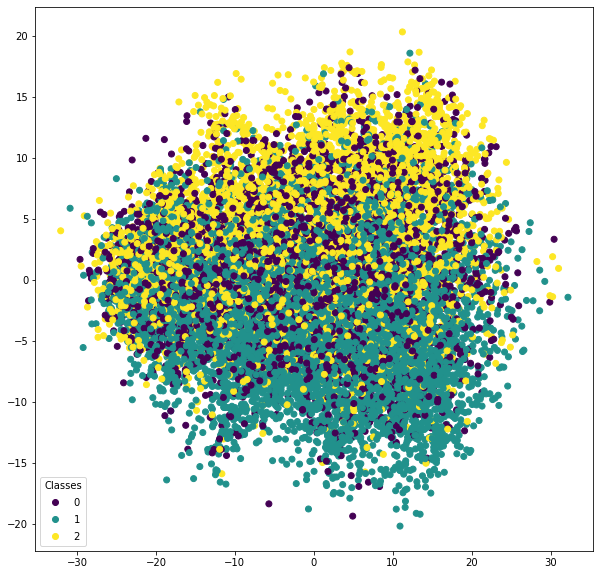

In [3]:
fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_new[:,0],X_new[:,1], c=y)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.savefig('./database/scatter.png')

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_new[:,0:2],y, test_size=0.2,random_state=0, stratify=y)